In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctl

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## dados com padronização

In [2]:
df_01 = pd.read_csv('df_02.csv')
del df_01['Unnamed: 0']

df_01.rename(columns = {'Pesquisas sobre IBOV':'IBOV', 
                        'Pesquisas sobre IBOVESPA':'IBOVESPA', 
                        'Pesquisas sobre BOVA11':'BOVA11',
                        'preco_ultimo_negocio':'preco_fechamento'}, inplace = True)

print(df_01.shape)
df_01.head()

(52, 8)


,IBOV,IBOVESPA,BOVA11,preco_abertura,preco_fechamento,qtd_negocios,qtd_papeis_negociados,vol_total_negociado
0,0.636,0.857,1.000,0.624,0.668,0.102,0.444,0.502
1,0.545,0.469,0.750,0.744,0.728,0.380,0.297,0.341
2,0.545,0.612,0.500,0.628,0.611,0.536,0.226,0.236
3,0.545,0.429,0.500,0.498,0.497,0.423,0.457,0.485
4,0.455,0.551,0.500,0.585,0.594,0.314,0.338,0.364


C:\Users\victo\AppData\Local\Temp/ipykernel_2360/3994492966.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_01[['IBOV', 'preco_fechamento', 'vol_total_negociado', 'qtd_papeis_negociados']].hist(ax = ax)


array([[<AxesSubplot:title={'center':'IBOV'}>,
        <AxesSubplot:title={'center':'preco_fechamento'}>],
       [<AxesSubplot:title={'center':'vol_total_negociado'}>,
        <AxesSubplot:title={'center':'qtd_papeis_negociados'}>]],
      dtype=object)

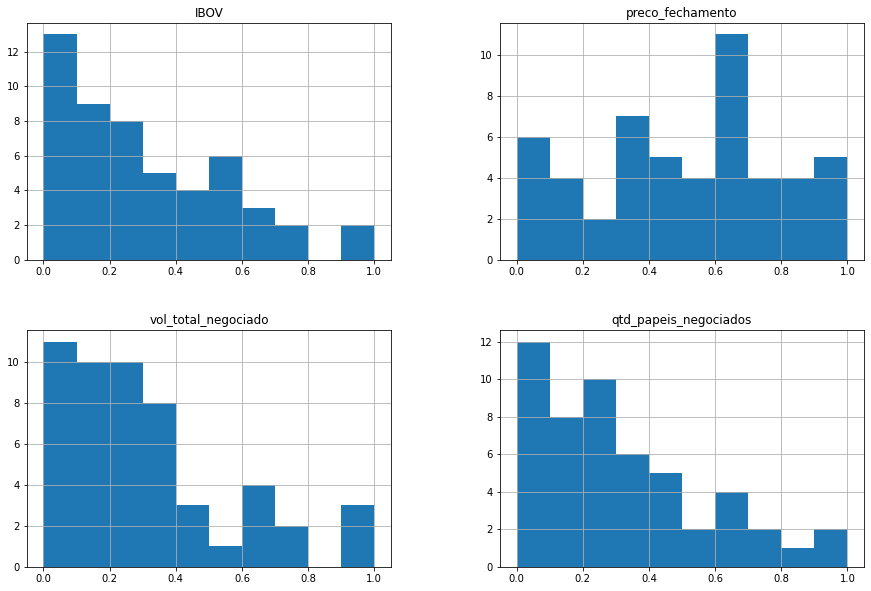

In [3]:
fig = plt.figure(figsize = (15, 10))
ax = fig.gca()
df_01[['IBOV', 'preco_fechamento', 'vol_total_negociado', 'qtd_papeis_negociados']].hist(ax = ax)

In [4]:
df_01[['IBOV', 'preco_fechamento', 'vol_total_negociado', 'qtd_papeis_negociados']].describe()

,IBOV,preco_fechamento,vol_total_negociado,qtd_papeis_negociados
count,52.000,52.000,52.000,52.000
mean,0.329,0.509,0.312,0.319
std,0.239,0.283,0.258,0.257
min,0.000,0.000,0.000,0.000
25%,0.159,0.317,0.132,0.127
50%,0.273,0.553,0.233,0.236
75%,0.477,0.699,0.404,0.418
max,1.000,1.000,1.000,1.000


In [5]:
# eixo das abscissas para as funções de pertinência

palavra = ctl.Antecedent(np.arange(0, 1.01, 0.01), 'IBOV')
volume = ctl.Antecedent(np.arange(0, 1.01, 0.01), 'volume')
dec = ctl.Consequent(np.arange(0, 1.01, 0.01), 'decisao')

## popularidade = volume

C:\Users\victo\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\victo\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Text(0.45, 0.8, 'cair')

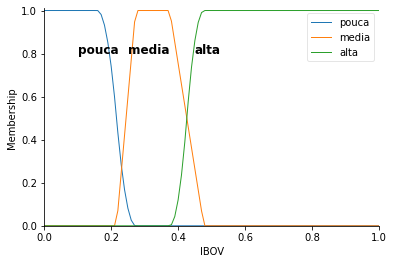

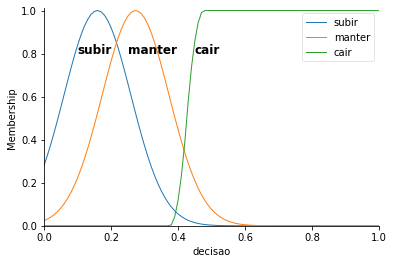

In [6]:
# funções de pertinência
from matplotlib.pyplot import figure

palavra['pouca'] = fuzz.zmf(palavra.universe, 0.159, 0.273)
palavra['media'] = fuzz.trapmf(palavra.universe, [0.216, 0.273, 0.375, 0.477])
palavra['alta'] = fuzz.smf(palavra.universe, 0.375, 0.477)
palavra.view()
plt.text(x = 0.1, y = 0.8, s = 'pouca', fontsize = 12, weight= 'bold')
plt.text(x = 0.25, y = 0.8, s = 'media', fontsize = 12, weight= 'bold')
plt.text(x = 0.45, y = 0.8, s = 'alta', fontsize = 12, weight= 'bold')

dec['subir'] = fuzz.gaussmf(dec.universe, 0.159, 0.1)
dec['manter'] = fuzz.gaussmf(dec.universe, 0.273, 0.1)
dec['cair'] = fuzz.smf(dec.universe, 0.375, 0.477)
dec.view()
plt.text(x = 0.1, y = 0.8, s = 'subir', fontsize = 12, weight= 'bold')
plt.text(x = 0.25, y = 0.8, s = 'manter', fontsize = 12, weight= 'bold')
plt.text(x = 0.45, y = 0.8, s = 'cair', fontsize = 12, weight= 'bold')

In [7]:
# regras da lógica fuzzy

regra1 = ctl.Rule(palavra['pouca'], dec['subir'])
regra2 = ctl.Rule(palavra['media'], dec['manter'])
regra3 = ctl.Rule(palavra['alta'], dec['cair'])

In [8]:
# sistema de criação de controle/simulação

decisao_ctl = ctl.ControlSystem([regra1, regra2, regra3])
decisao = ctl.ControlSystemSimulation(decisao_ctl)

In [9]:
mval = np.zeros((len(df_01['vol_total_negociado']), 3))

In [10]:
# função de cálculo para desfuzzificação

def IndFzy(entrada):
    decisao.input['IBOV'] = entrada[0]
    decisao.compute()
    return(decisao.output['decisao'])

Text(0, 0.5, 'google trends - "IBOV"')

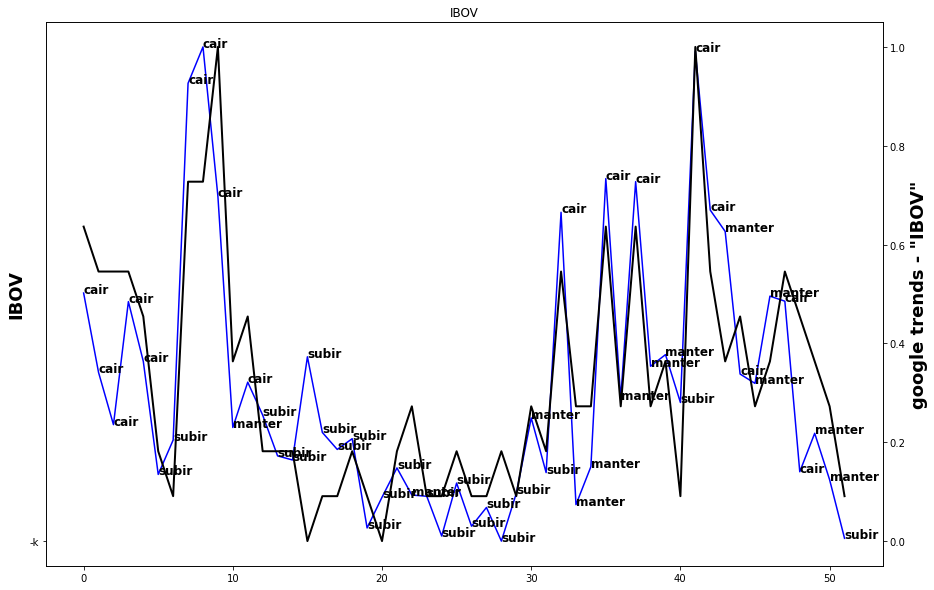

In [11]:
# decisão final

for i in range(len(df_01['vol_total_negociado'])):
    res1 = IndFzy([df_01['IBOV'].values[i], df_01['vol_total_negociado'].values[i]])
    j = 0
    for t in dec.terms:
        s = np.interp(res1, dec.universe, dec[t].mf)
        mval[i, j] = s
        j = j + 1
        
mval = pd.DataFrame(mval, columns = ['subir', 'manter', 'cair'])
dec_fuzzy = mval.idxmax(axis = 1)

# dec.view(sim = decisao)
# plt.text(x = 0.159091, y = 0.8, s = 'subir', fontsize = 18, weight= 'bold')
# plt.text(x = 0.272727, y = 0.8, s = 'manter', fontsize = 18, weight= 'bold')
# plt.text(x = 0.477273, y = 0.8, s = 'cair', fontsize = 18, weight= 'bold')

fig = plt.figure(0, figsize = (15, 10))
ax1 = plt.subplot(111)
plt.title('IBOV')

ax1.plot(df_01['vol_total_negociado'].index, df_01['vol_total_negociado'].values, '-b', '-k')
ax1.set_ylabel('IBOV', fontsize = 18, weight = 'bold')
for i in range(len(dec_fuzzy)):
    ax1.text(x = df_01['vol_total_negociado'].index[i], y = df_01['vol_total_negociado'].values[i], s = str(dec_fuzzy[i]), fontsize = 12, color = 'black', weight ='bold')
    
ax2 = ax1.twinx()
ax2.plot(df_01.index, df_01['IBOV'], color = 'black', linewidth = 2)
ax2.set_ylabel('google trends - "IBOV"', fontsize = 18, weight = 'bold')

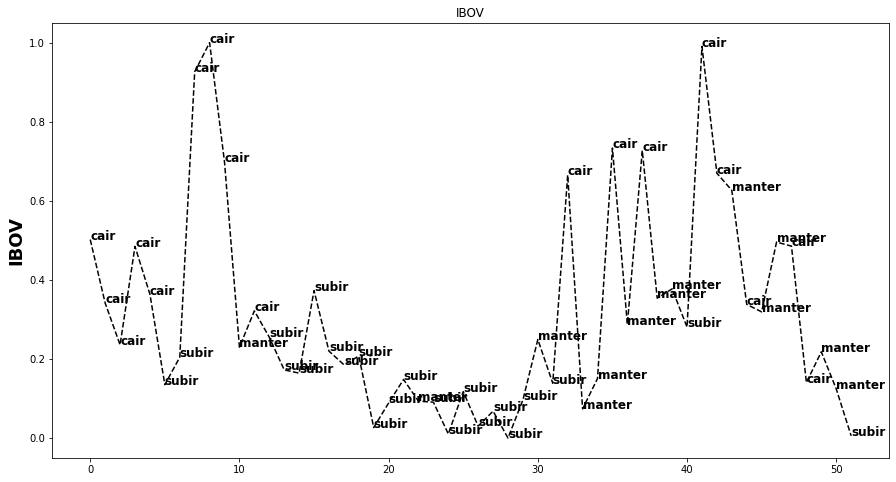

In [12]:
fig = plt.figure(0, figsize = (15, 8))
ax1 = plt.subplot(111)
plt.title('IBOV')

ax1.plot(df_01['vol_total_negociado'].index, df_01['vol_total_negociado'].values, '--k')
ax1.set_ylabel('IBOV', fontsize = 18, weight = 'bold')
for i in range(len(dec_fuzzy)):
    ax1.text(x = df_01['vol_total_negociado'].index[i], y = df_01['vol_total_negociado'].values[i], s = str(dec_fuzzy[i]), fontsize = 12, color = 'black', weight ='bold')

In [13]:
saida = pd.DataFrame(dec_fuzzy, columns = ['decisao'])

df_01['decisao'] = saida['decisao']
#df_01.to_excel('avalia_01.xlsx')
df_01.head()

,IBOV,IBOVESPA,BOVA11,preco_abertura,preco_fechamento,qtd_negocios,qtd_papeis_negociados,vol_total_negociado,decisao
0,0.636,0.857,1.000,0.624,0.668,0.102,0.444,0.502,cair
1,0.545,0.469,0.750,0.744,0.728,0.380,0.297,0.341,cair
2,0.545,0.612,0.500,0.628,0.611,0.536,0.226,0.236,cair
3,0.545,0.429,0.500,0.498,0.497,0.423,0.457,0.485,cair
4,0.455,0.551,0.500,0.585,0.594,0.314,0.338,0.364,cair


## popularidade + volume = preço

C:\Users\victo\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\victo\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\victo\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Text(0.45, 0.8, 'cair')

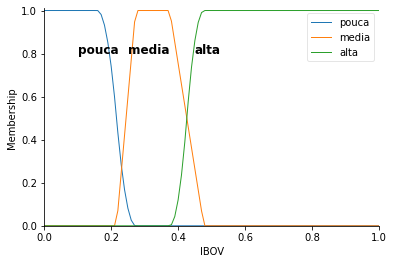

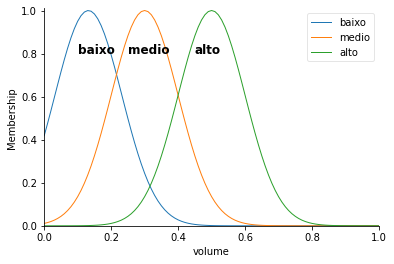

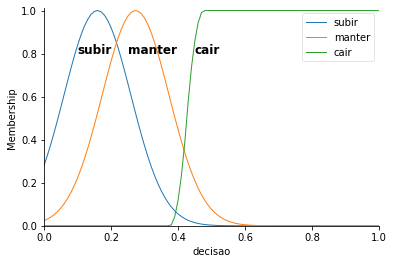

In [14]:
# funções de pertinência
from matplotlib.pyplot import figure

palavra['pouca'] = fuzz.zmf(palavra.universe, 0.159, 0.273)
palavra['media'] = fuzz.trapmf(palavra.universe, [0.216, 0.273, 0.375, 0.477])
palavra['alta'] = fuzz.smf(palavra.universe, 0.375, 0.477)
palavra.view()
plt.text(x = 0.1, y = 0.8, s = 'pouca', fontsize = 12, weight= 'bold')
plt.text(x = 0.25, y = 0.8, s = 'media', fontsize = 12, weight= 'bold')
plt.text(x = 0.45, y = 0.8, s = 'alta', fontsize = 12, weight= 'bold')

volume['baixo'] = fuzz.gaussmf(volume.universe, 0.132, 0.1)
volume['medio'] = fuzz.gaussmf(volume.universe, 0.3, 0.1)
volume['alto'] = fuzz.gaussmf(volume.universe, 0.5, 0.1)
volume.view()
plt.text(x = 0.1, y = 0.8, s = 'baixo', fontsize = 12, weight= 'bold')
plt.text(x = 0.25, y = 0.8, s = 'medio', fontsize = 12, weight= 'bold')
plt.text(x = 0.45, y = 0.8, s = 'alto', fontsize = 12, weight= 'bold')

dec['subir'] = fuzz.gaussmf(dec.universe, 0.159, 0.1)
dec['manter'] = fuzz.gaussmf(dec.universe, 0.273, 0.1)
dec['cair'] = fuzz.smf(dec.universe, 0.375, 0.477)
dec.view()
plt.text(x = 0.1, y = 0.8, s = 'subir', fontsize = 12, weight= 'bold')
plt.text(x = 0.25, y = 0.8, s = 'manter', fontsize = 12, weight= 'bold')
plt.text(x = 0.45, y = 0.8, s = 'cair', fontsize = 12, weight= 'bold')

In [15]:
# regras da lógica fuzzy

regra1 = ctl.Rule(palavra['pouca'] & volume['baixo'], dec['subir'])
regra2 = ctl.Rule(palavra['pouca'] & volume['alto'], dec['cair'])
regra3 = ctl.Rule(palavra['media'] & volume['baixo'], dec['subir'])
regra4 = ctl.Rule(palavra['media'] & volume['medio'], dec['manter'])
regra5 = ctl.Rule(palavra['media'] & volume['alto'], dec['cair'])
regra6 = ctl.Rule(palavra['alta'] & volume['alto'], dec['cair'])

In [16]:
# sistema de criação de controle/simulação

decisao_ctl = ctl.ControlSystem([regra1, regra2, regra3, regra4, regra5, regra6])
decisao = ctl.ControlSystemSimulation(decisao_ctl)

In [17]:
mval = np.zeros((len(df_01['vol_total_negociado']), 3))

In [18]:
# função de cálculo para desfuzzificação

def IndFzy(entrada):
    decisao.input['IBOV'] = entrada[0]
    decisao.input['volume'] = entrada[1]
    decisao.compute()
    return(decisao.output['decisao'])

C:\Users\victo\AppData\Local\Temp/ipykernel_2360/169378060.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  mval[i, j] = s


Text(0, 0.5, 'google trends - "IBOV"')

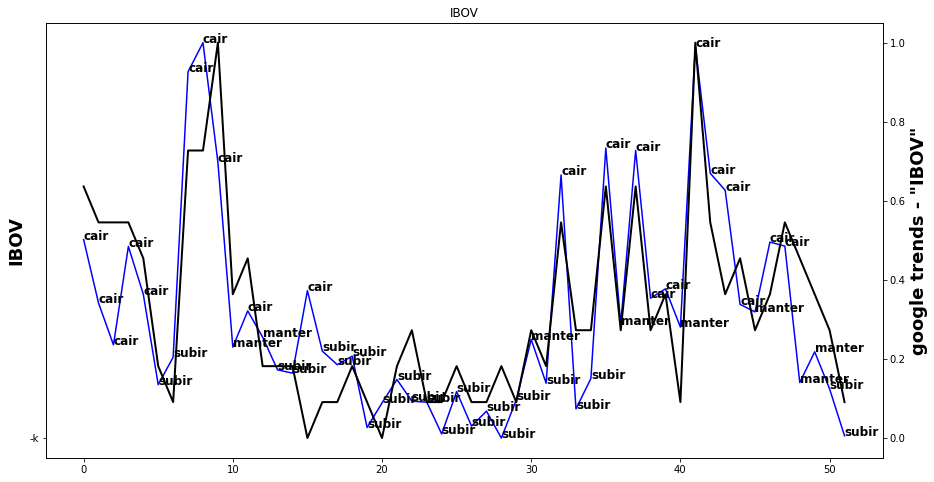

In [21]:
# decisão final

for i in range(len(df_01['vol_total_negociado'])):
    res1 = IndFzy([df_01['IBOV'].values[i], df_01['vol_total_negociado'].values[i]])
    j = 0
    for t in dec.terms:
        s = np.interp(res1, dec.universe, dec[t].mf)
        mval[i, j] = s
        j = j + 1
        
mval = pd.DataFrame(mval, columns = ['subir', 'manter', 'cair'])
dec_fuzzy = mval.idxmax(axis = 1)

# dec.view(sim = decisao)
# plt.text(x = 0.159091, y = 0.8, s = 'subir', fontsize = 18, weight= 'bold')
# plt.text(x = 0.272727, y = 0.8, s = 'manter', fontsize = 18, weight= 'bold')
# plt.text(x = 0.477273, y = 0.8, s = 'cair', fontsize = 18, weight= 'bold')

fig = plt.figure(0, figsize = (15, 8))
ax1 = plt.subplot(111)
plt.title('IBOV')

ax1.plot(df_01['vol_total_negociado'].index, df_01['vol_total_negociado'].values, '-b', '-k')
ax1.set_ylabel('IBOV', fontsize = 18, weight = 'bold')
for i in range(len(dec_fuzzy)):
    ax1.text(x = df_01['vol_total_negociado'].index[i], y = df_01['vol_total_negociado'].values[i], s = str(dec_fuzzy[i]), fontsize = 12, color = 'black', weight ='bold')
    
ax2 = ax1.twinx()
ax2.plot(df_01.index, df_01['IBOV'], color = 'black', linewidth = 2)
ax2.set_ylabel('google trends - "IBOV"', fontsize = 18, weight = 'bold')

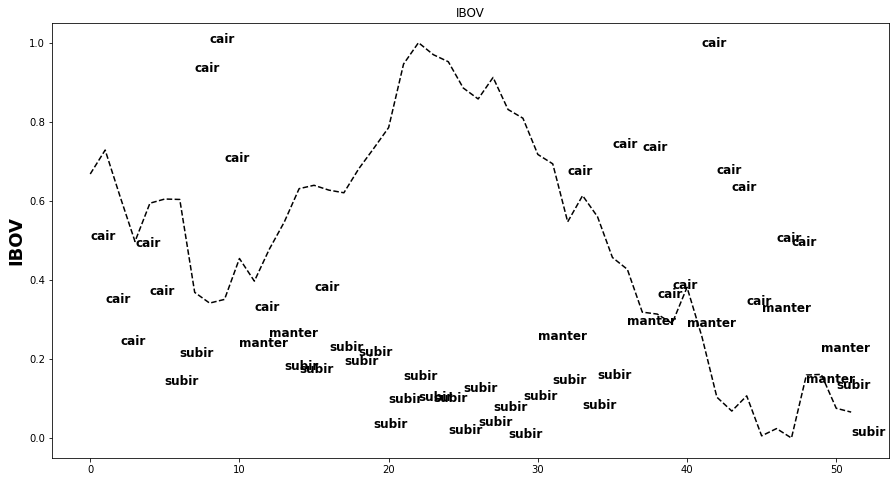

In [22]:
fig = plt.figure(0, figsize = (15, 8))
ax1 = plt.subplot(111)
plt.title('IBOV')

ax1.plot(df_01['preco_fechamento'].index, df_01['preco_fechamento'].values, '--k')
ax1.set_ylabel('IBOV', fontsize = 18, weight = 'bold')
for i in range(len(dec_fuzzy)):
    ax1.text(x = df_01['vol_total_negociado'].index[i], y = df_01['vol_total_negociado'].values[i], s = str(dec_fuzzy[i]), fontsize = 12, color = 'black', weight ='bold')

In [23]:
saida = pd.DataFrame(dec_fuzzy, columns = ['decisao'])

df_01['decisao'] = saida['decisao']
#df_01.to_excel('avalia_02.xlsx')
df_01.head()

,IBOV,IBOVESPA,BOVA11,preco_abertura,preco_fechamento,qtd_negocios,qtd_papeis_negociados,vol_total_negociado,decisao
0,0.636,0.857,1.000,0.624,0.668,0.102,0.444,0.502,cair
1,0.545,0.469,0.750,0.744,0.728,0.380,0.297,0.341,cair
2,0.545,0.612,0.500,0.628,0.611,0.536,0.226,0.236,cair
3,0.545,0.429,0.500,0.498,0.497,0.423,0.457,0.485,cair
4,0.455,0.551,0.500,0.585,0.594,0.314,0.338,0.364,cair


## dados sem padronização

In [24]:
df_01 = pd.read_csv('df_01.csv')
del df_01['Unnamed: 0']

df_01.rename(columns = {'Pesquisas sobre IBOV':'IBOV', 
                        'Pesquisas sobre IBOVESPA':'IBOVESPA', 
                        'Pesquisas sobre BOVA11':'BOVA11',
                        'preco_ultimo_negocio':'preco_fechamento'}, inplace = True)

print(df_01.shape)
df_01.head()

(52, 8)


,IBOV,IBOVESPA,BOVA11,preco_abertura,preco_fechamento,qtd_negocios,qtd_papeis_negociados,vol_total_negociado
0,13,93,5,115.502,116.420,27410.800,9682772.000,1125451362.560
1,12,74,4,118.610,117.978,44778.400,8049082.000,950649362.140
2,12,81,3,115.598,114.954,54571.000,7266464.000,835525470.800
3,12,72,3,112.245,112.028,47507.000,9828950.000,1106573946.625
4,11,78,3,114.492,114.520,40661.200,8508734.000,974939985.260


C:\Users\victo\AppData\Local\Temp/ipykernel_2360/3994492966.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_01[['IBOV', 'preco_fechamento', 'vol_total_negociado', 'qtd_papeis_negociados']].hist(ax = ax)


array([[<AxesSubplot:title={'center':'IBOV'}>,
        <AxesSubplot:title={'center':'preco_fechamento'}>],
       [<AxesSubplot:title={'center':'vol_total_negociado'}>,
        <AxesSubplot:title={'center':'qtd_papeis_negociados'}>]],
      dtype=object)

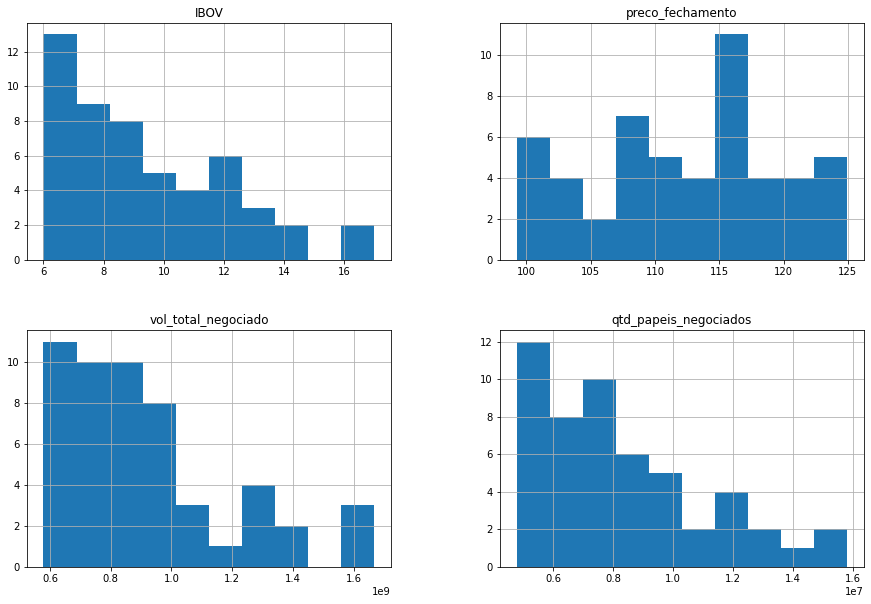

In [25]:
fig = plt.figure(figsize = (15, 10))
ax = fig.gca()
df_01[['IBOV', 'preco_fechamento', 'vol_total_negociado', 'qtd_papeis_negociados']].hist(ax = ax)

In [26]:
df_01[['IBOV', 'preco_fechamento', 'vol_total_negociado', 'qtd_papeis_negociados']].describe()

,IBOV,preco_fechamento,vol_total_negociado,qtd_papeis_negociados
count,52.000,52.000,52.000,52.000
mean,9.615,112.331,919001194.866,8292503.606
std,2.628,7.272,280897067.034,2845814.398
min,6.000,99.240,578953066.800,4770112.000
25%,7.750,107.400,722921745.700,6169540.625
50%,9.000,113.474,832404274.460,7375456.000
75%,11.250,117.233,1018960232.316,9394721.750
max,17.000,124.964,1667738226.300,15828328.000


In [47]:
# eixo das abscissas para as funções de pertinência

palavra = ctl.Antecedent(np.arange(5, 20, 0.1), 'IBOV')
volume = ctl.Antecedent(np.arange(578953000, 1667739000, 1000000), 'volume')
dec = ctl.Consequent(np.arange(5, 20, 0.1), 'decisao')

## popularidade = volume

C:\Users\victo\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\victo\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Text(13, 0.8, 'cair')

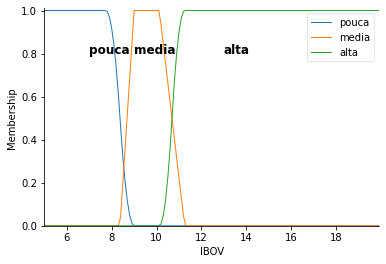

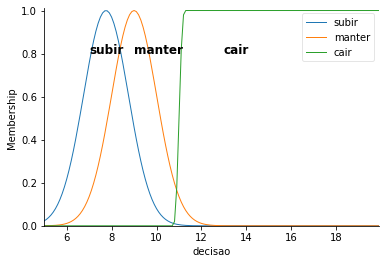

In [55]:
# funções de pertinência
from matplotlib.pyplot import figure

palavra['pouca'] = fuzz.zmf(palavra.universe, 7.750, 9)
palavra['media'] = fuzz.trapmf(palavra.universe, [8.375, 9.0, 10.125, 11.250])
palavra['alta'] = fuzz.smf(palavra.universe, 10.125, 11.250)
palavra.view()
plt.text(x = 7, y = 0.8, s = 'pouca', fontsize = 12, weight= 'bold')
plt.text(x = 9, y = 0.8, s = 'media', fontsize = 12, weight= 'bold')
plt.text(x = 13, y = 0.8, s = 'alta', fontsize = 12, weight= 'bold')

dec['subir'] = fuzz.gaussmf(dec.universe, 7.750, 1)
dec['manter'] = fuzz.gaussmf(dec.universe, 9, 1)
dec['cair'] = fuzz.smf(dec.universe, 10.75, 11.250)
dec.view()
plt.text(x = 7, y = 0.8, s = 'subir', fontsize = 12, weight= 'bold')
plt.text(x = 9, y = 0.8, s = 'manter', fontsize = 12, weight= 'bold')
plt.text(x = 13, y = 0.8, s = 'cair', fontsize = 12, weight= 'bold')

In [56]:
# regras da lógica fuzzy

regra1 = ctl.Rule(palavra['pouca'], dec['subir'])
regra2 = ctl.Rule(palavra['media'], dec['manter'])
regra3 = ctl.Rule(palavra['alta'], dec['cair'])

In [57]:
# sistema de criação de controle/simulação

decisao_ctl = ctl.ControlSystem([regra1, regra2, regra3])
decisao = ctl.ControlSystemSimulation(decisao_ctl)

In [58]:
mval = np.zeros((len(df_01['vol_total_negociado']), 3))

In [59]:
# função de cálculo para desfuzzificação

def IndFzy(entrada):
    decisao.input['IBOV'] = entrada[0]
    decisao.compute()
    return(decisao.output['decisao'])

C:\Users\victo\AppData\Local\Temp/ipykernel_2360/235045032.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(df_01['vol_total_negociado'].index, df_01['vol_total_negociado'].values, '--k', color = 'red')


Text(0, 0.5, 'google trends - "IBOV"')

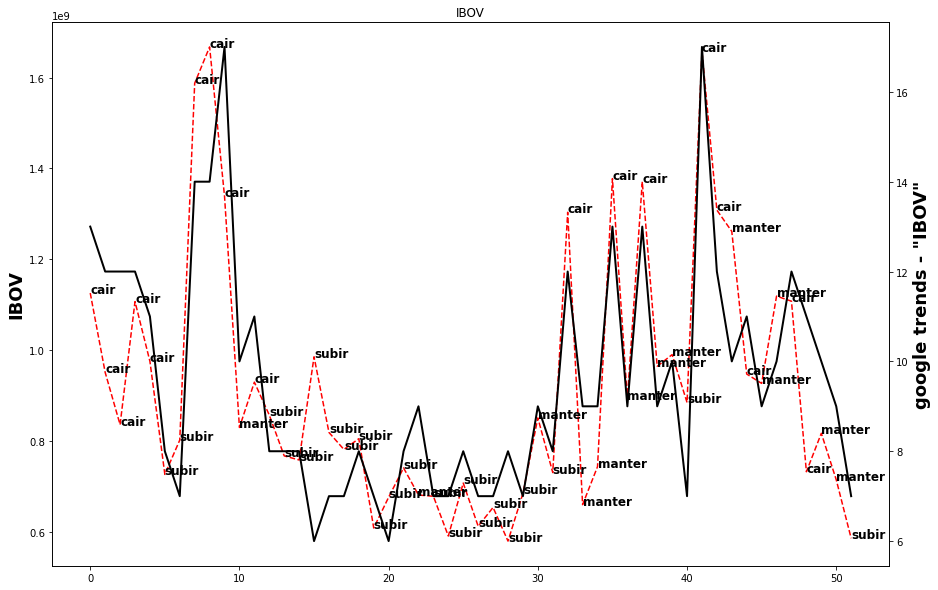

In [60]:
# decisão final

for i in range(len(df_01['vol_total_negociado'])):
    res1 = IndFzy([df_01['IBOV'].values[i], df_01['vol_total_negociado'].values[i]])
    j = 0
    for t in dec.terms:
        s = np.interp(res1, dec.universe, dec[t].mf)
        mval[i, j] = s
        j = j + 1
        
mval = pd.DataFrame(mval, columns = ['subir', 'manter', 'cair'])
dec_fuzzy = mval.idxmax(axis = 1)

# dec.view(sim = decisao)
# plt.text(x = 0.159091, y = 0.8, s = 'subir', fontsize = 18, weight= 'bold')
# plt.text(x = 0.272727, y = 0.8, s = 'manter', fontsize = 18, weight= 'bold')
# plt.text(x = 0.477273, y = 0.8, s = 'cair', fontsize = 18, weight= 'bold')

fig = plt.figure(0, figsize = (15, 10))
ax1 = plt.subplot(111)
plt.title('IBOV')

ax1.plot(df_01['vol_total_negociado'].index, df_01['vol_total_negociado'].values, '--k', color = 'red')
ax1.set_ylabel('IBOV', fontsize = 18, weight = 'bold')
for i in range(len(dec_fuzzy)):
    ax1.text(x = df_01['vol_total_negociado'].index[i], y = df_01['vol_total_negociado'].values[i], s = str(dec_fuzzy[i]), fontsize = 12, color = 'black', weight ='bold')
    
ax2 = ax1.twinx()
ax2.plot(df_01.index, df_01['IBOV'], color = 'black', linewidth = 2)
ax2.set_ylabel('google trends - "IBOV"', fontsize = 18, weight = 'bold')

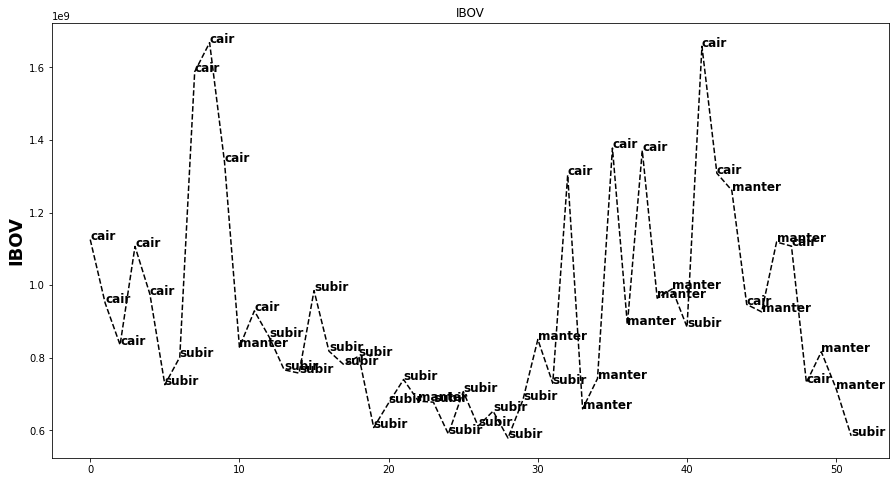

In [61]:
fig = plt.figure(0, figsize = (15, 8))
ax1 = plt.subplot(111)
plt.title('IBOV')

ax1.plot(df_01['vol_total_negociado'].index, df_01['vol_total_negociado'].values, '--k')
ax1.set_ylabel('IBOV', fontsize = 18, weight = 'bold')
for i in range(len(dec_fuzzy)):
    ax1.text(x = df_01['vol_total_negociado'].index[i], y = df_01['vol_total_negociado'].values[i], s = str(dec_fuzzy[i]), fontsize = 12, color = 'black', weight ='bold')

In [62]:
saida = pd.DataFrame(dec_fuzzy, columns = ['decisao'])

df_01['decisao'] = saida['decisao']
#df_01.to_excel('avalia_01.xlsx')
df_01.head()

,IBOV,IBOVESPA,BOVA11,preco_abertura,preco_fechamento,qtd_negocios,qtd_papeis_negociados,vol_total_negociado,decisao
0,13,93,5,115.502,116.420,27410.800,9682772.000,1125451362.560,cair
1,12,74,4,118.610,117.978,44778.400,8049082.000,950649362.140,cair
2,12,81,3,115.598,114.954,54571.000,7266464.000,835525470.800,cair
3,12,72,3,112.245,112.028,47507.000,9828950.000,1106573946.625,cair
4,11,78,3,114.492,114.520,40661.200,8508734.000,974939985.260,cair
